# Loading Data

## Load Viewer/Chat/Twitter Data

In [187]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from __future__ import unicode_literals

plt.style.use('fivethirtyeight')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['xtick.color'] = 'grey'
plt.rcParams['ytick.color'] = 'grey'

with open('marathon_data/sgdq2016final.json') as f:
    raw_data = json.loads(f.read())
games = map(lambda x: raw_data['games'][x], raw_data['games'])
games.sort(lambda x, y: x['start_time'] - y['start_time'])

marathon_data = []
# Deep dictionary merge
for time_key in list(set(raw_data['data'].keys()).union(raw_data['extras'].keys())):
    payload = {}
    payload['time'] = int(time_key)
    if time_key in raw_data['data']:
        payload.update(raw_data['data'][time_key])
    if time_key in raw_data['extras']:
        payload.update(raw_data['extras'][time_key])
    for idx, i in enumerate(games):
        if int(i['start_time']) > int(payload['time']):
            payload['game'] = games[idx-1]['title'] if idx - 1 > 0 else np.nan
            break
    marathon_data.append(payload)
graph_df = pd.DataFrame(marathon_data)
graph_df['time'] = pd.to_datetime(graph_df['time'], unit='ms')
graph_df = graph_df.set_index('time').sort_index()
graph_df = graph_df.tz_localize('UTC').tz_convert('US/Central')
graph_df['cum_emotes'] = graph_df.e.cumsum()
graph_df['cum_chats']  = graph_df.c.cumsum()
graph_df['avg_don'] = graph_df.m / graph_df.d
graph_df['m_per_min'] = graph_df.m.diff()

## Load Bid Tracker Data

In [165]:
with open('marathon_data/killVsSave.json') as f:
    raw_bid_data = json.loads(f.read())
bid_data = []
kill_data = raw_bid_data['ys'][0][1:]
save_data = raw_bid_data['ys'][1][1:]

for idx, time in enumerate(raw_bid_data['x'][1:]):
    payload = {
        'time': time,
        'kill': kill_data[idx],
        'save': save_data[idx]
    }
    bid_data.append(payload)
bid_df = pd.DataFrame(bid_data)
bid_df.time = pd.to_datetime(bid_df['time'],unit='ms')
bid_df = bid_df.set_index('time').sort_index()
bid_df = bid_df.tz_localize('UTC').tz_convert('US/Central')
bid_df['cum_kill'] = bid_df.kill.cumsum()
bid_df['cum_save'] = bid_df.save.cumsum()
bid_df['kill_over_save'] = bid_df['cum_kill'] - bid_df['cum_save']
bid_df['kill_over_save_pos'] = bid_df['kill_over_save'] > 0


kill    float64
save    float64
time      int64
dtype: object


# Visualizations

## Save vs. Kill the Animals

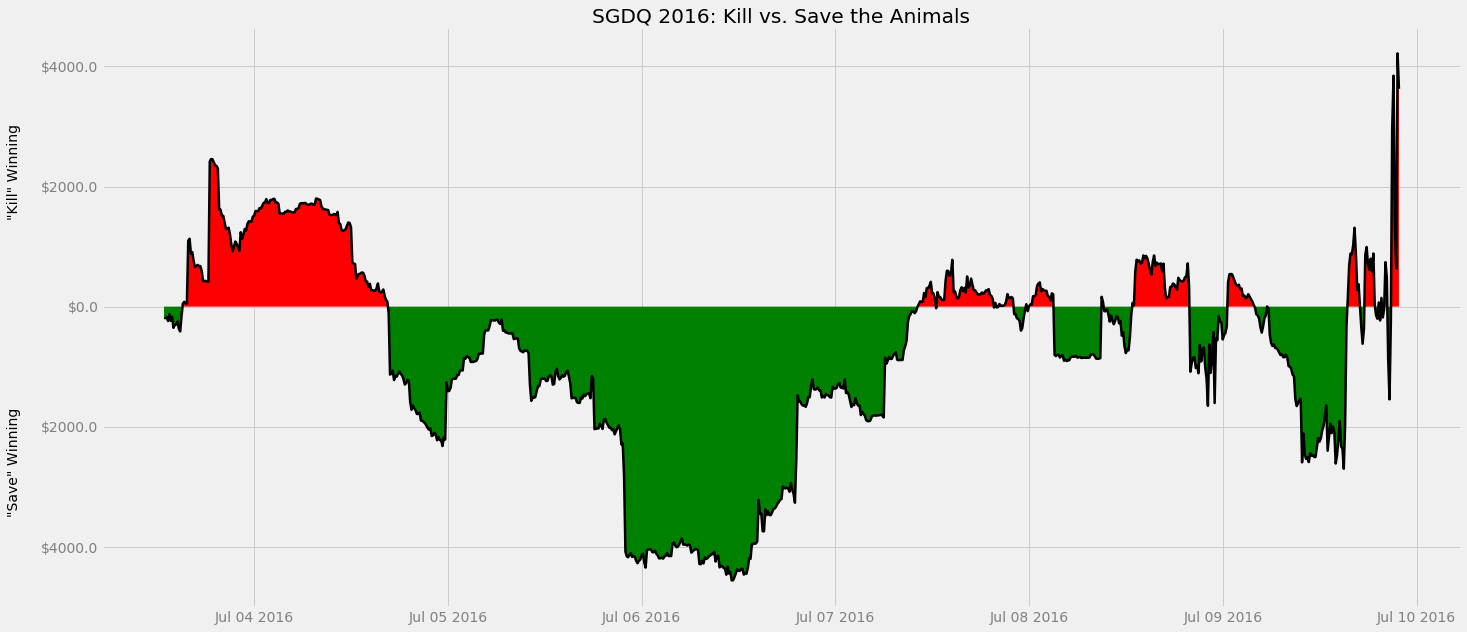

In [55]:
plt.rcParams["figure.figsize"] = (20,9)
fig, ax = plt.subplots()
plt.plot(bid_df.index, bid_df.kill_over_save, color='black', linewidth=2.5)
plt.fill_between(bid_df.index, bid_df.kill_over_save, where=bid_df.kill_over_save_pos, facecolor='red', interpolate=True)
plt.fill_between(bid_df.index, bid_df.kill_over_save, where=bid_df.kill_over_save_pos == False, facecolor='green', interpolate=True)
plt.title("SGDQ 2016: Kill vs. Save the Animals")
plt.tight_layout()
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(abs(x))))
ax.text(-.07, 0.75, '"Kill" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
ax.text(-.07, 0.25, '"Save" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
plt.savefig('./after/img/kill_vs_save.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/kill_vs_save.png', bbox_inches='tight', dpi=500)


2016-07-09 19:00:00


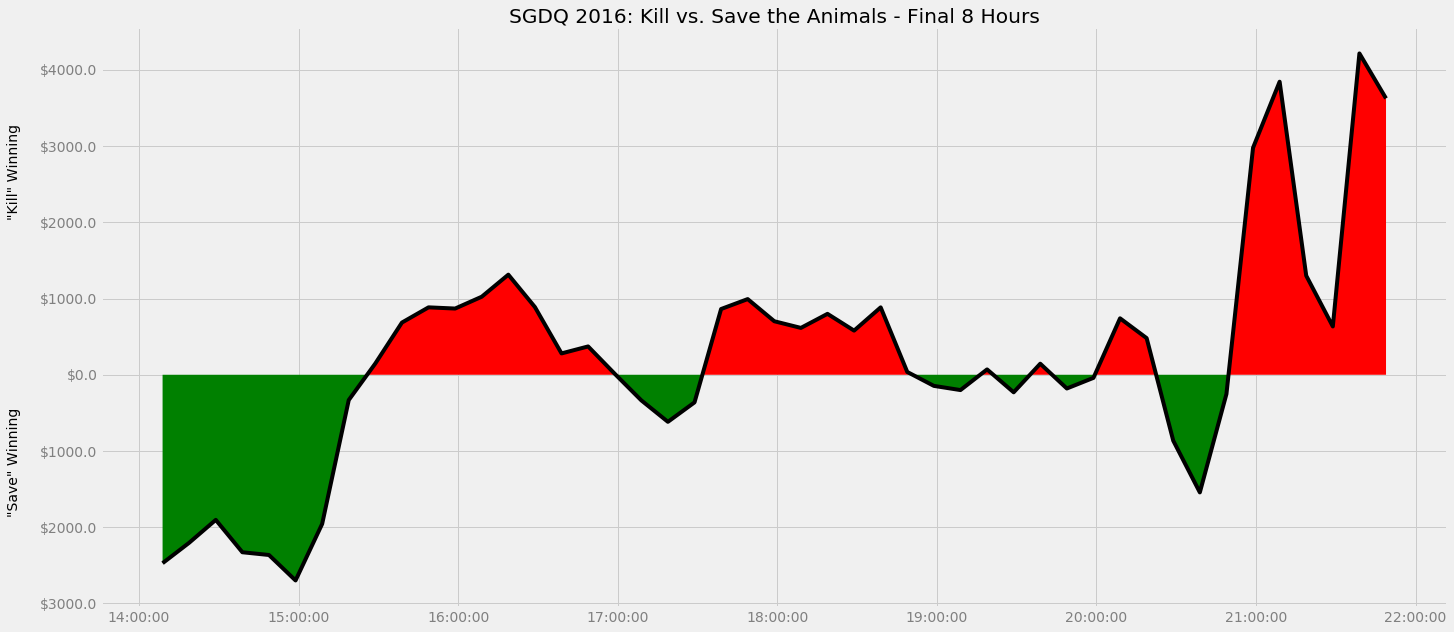

In [57]:
start_time = pd.to_datetime(1468090800, unit='s')
print start_time
bid_df_sliced = bid_df[bid_df.index > start_time]
plt.rcParams["figure.figsize"] = (20,9)
fig, ax = plt.subplots()
plt.plot(bid_df_sliced.index, bid_df_sliced.kill_over_save, color='black')
plt.fill_between(bid_df_sliced.index, bid_df_sliced.kill_over_save, where=bid_df_sliced.kill_over_save_pos, facecolor='red', interpolate=True)
plt.fill_between(bid_df_sliced.index, bid_df_sliced.kill_over_save, where=bid_df_sliced.kill_over_save_pos == False, facecolor='green', interpolate=True)
plt.title("SGDQ 2016: Kill vs. Save the Animals - Final 8 Hours")
ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: "$" + str(abs(x))))
ax.text(-.07, 0.75, '"Kill" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
ax.text(-.07, 0.25, '"Save" Winning',
     horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes,
     rotation=90)
plt.tight_layout()
plt.savefig('./after/img/kill_vs_save_last_8.png', bbox_inches='tight', dpi=100)
plt.savefig('./after/render/kill_vs_save_last_8.png', bbox_inches='tight', dpi=500)

## Max Viewers

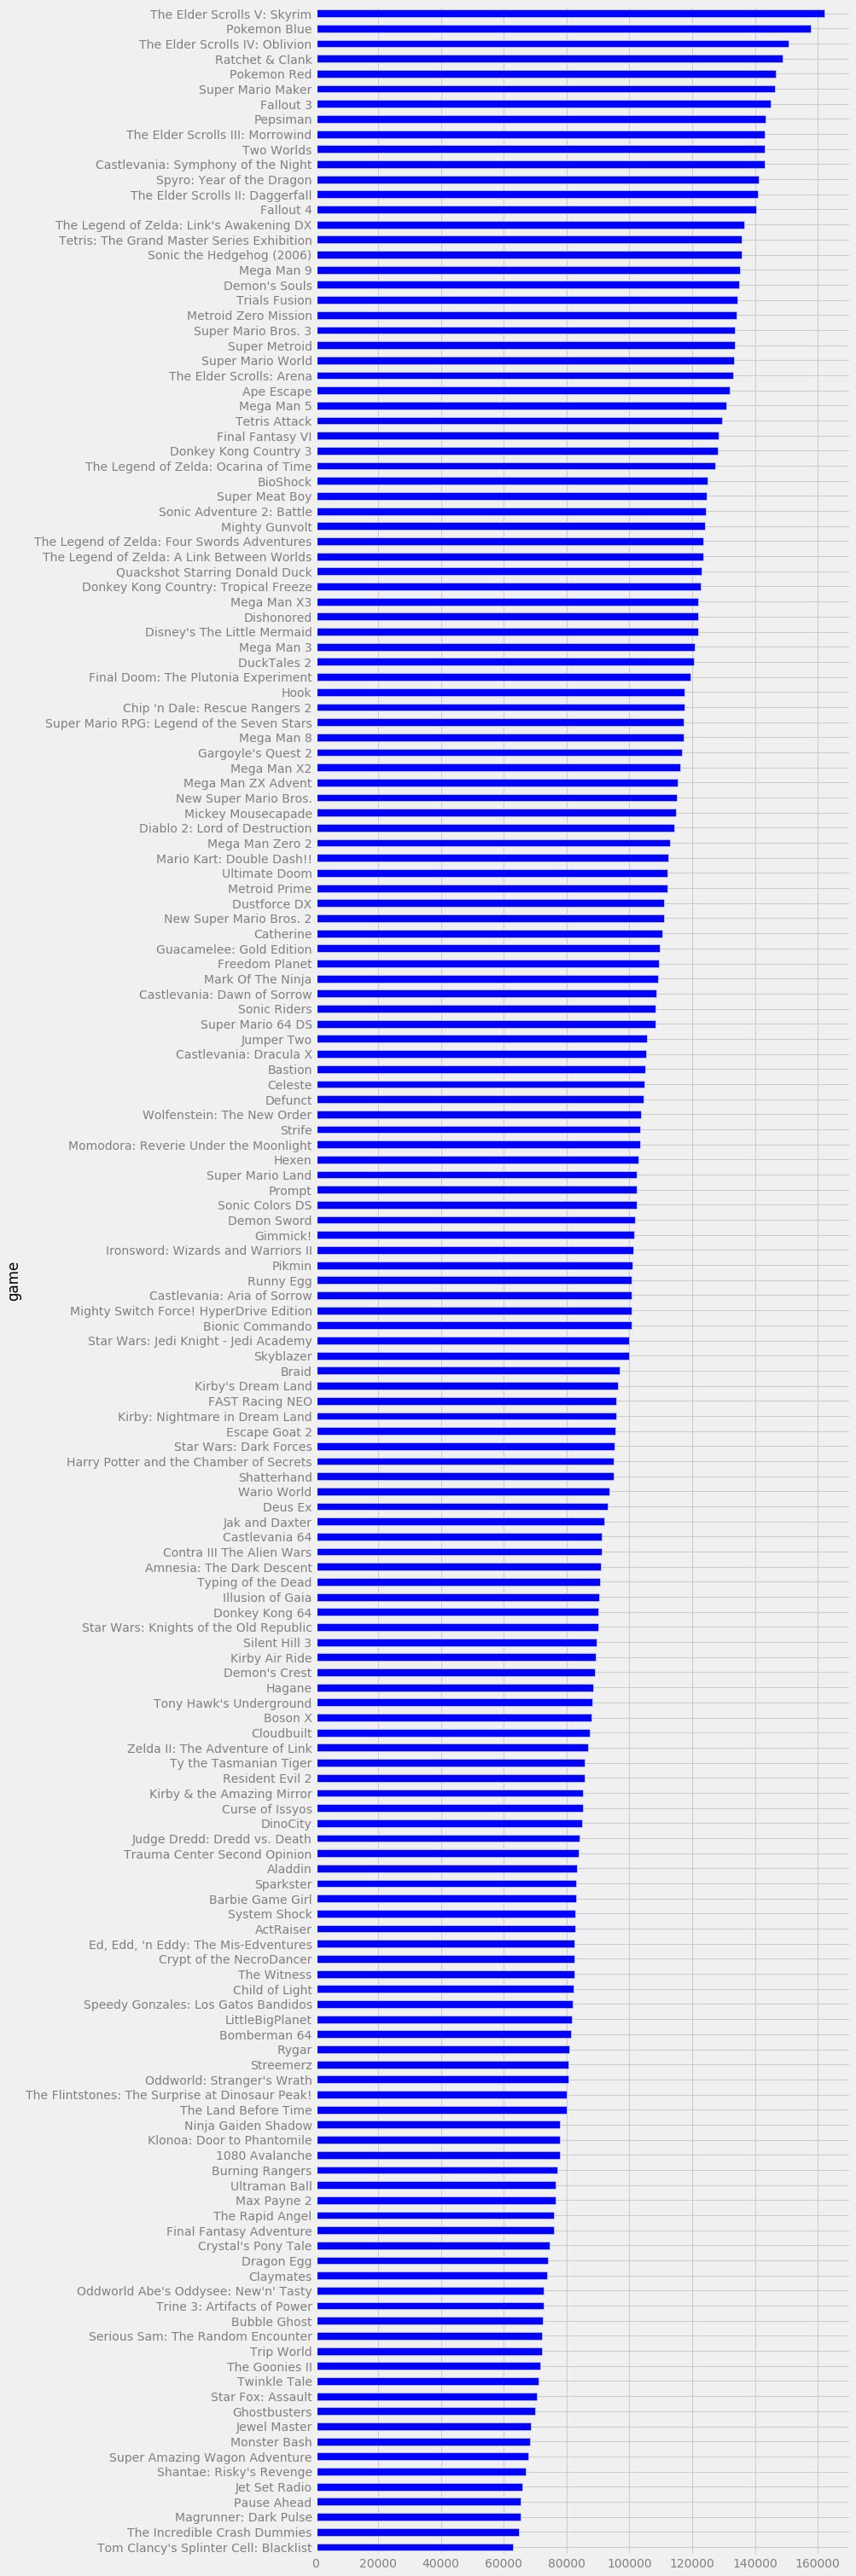

In [144]:
max_v_df =  graph_df.groupby(['game'])['v'].max()
max_v_df = max_v_df.sort_values(ascending=True)
max_v_df.plot(kind='barh', figsize=(10,50))

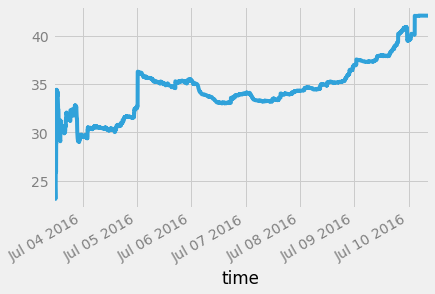

In [186]:
graph_df.avg_don.plot.line()

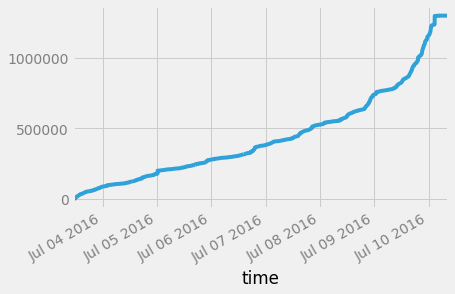

In [188]:
graph_df.m.plot.line()

In [196]:
pd.rolling_mean(graph_df.m_per_min, 60)

time
2016-07-03 10:43:00-05:00         NaN
2016-07-03 10:44:00-05:00         NaN
2016-07-03 10:45:00-05:00         NaN
2016-07-03 10:46:00-05:00         NaN
2016-07-03 10:47:00-05:00         NaN
2016-07-03 10:48:00-05:00         NaN
2016-07-03 10:49:00-05:00         NaN
2016-07-03 10:50:00-05:00         NaN
2016-07-03 10:51:00-05:00         NaN
2016-07-03 10:52:00-05:00         NaN
2016-07-03 10:53:00-05:00         NaN
2016-07-03 10:54:00-05:00         NaN
2016-07-03 10:55:00-05:00         NaN
2016-07-03 10:56:00-05:00         NaN
2016-07-03 10:57:00-05:00         NaN
2016-07-03 10:58:00-05:00         NaN
2016-07-03 10:59:00-05:00         NaN
2016-07-03 11:00:00-05:00         NaN
2016-07-03 11:01:00-05:00         NaN
2016-07-03 11:02:00-05:00         NaN
2016-07-03 11:03:00-05:00         NaN
2016-07-03 11:04:00-05:00         NaN
2016-07-03 11:05:00-05:00         NaN
2016-07-03 11:06:00-05:00         NaN
2016-07-03 11:07:00-05:00         NaN
2016-07-03 11:08:00-05:00         NaN
2016-07

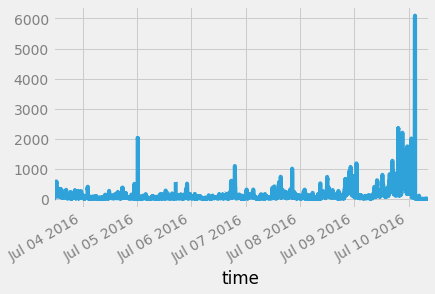